# Probabilistic Signal Estimator

The question we want to answer is the following. How long does it take to reach +2% gain from now?

In [56]:
from hypecommons import *
from hypecommons import plot as hyplot

from datetime import datetime, timedelta

In [59]:
SYMBOL = 'BNBBUSD'
FREQ = 1
START = '20210101000000'
TARGET = 1.02
DAYS = 150

In [60]:
df = download_history_fast(SYMBOL, START, freq=FREQ, days=DAYS)

In [61]:
print(str(df.iloc[0]) + '\n\n' + str(df.iloc[-1]))

open      37.4121
high      37.4258
low       37.3931
close     37.4160
volume    91.8900
trades    30.0000
Name: 2021-01-01 00:00:00, dtype: float64

open       325.8400
high       325.8400
low        323.2600
close      323.4800
volume    1230.1234
trades     762.0000
Name: 2021-05-31 01:00:00, dtype: float64


As the goal is to achieve a given value, the `high` price value is used. Binance allows users to create future orders with a limit, therefore this behaviour can be reproduced also in a real-time setting.

In [62]:
def minutes_to_target(df, start, target):
    t0 = df.index[start]
    close0 = df['close'].iloc[start]
    try:
        t1 = df[(df.index > t0) & (df['high'] >= target * close0)].index[0]
    except IndexError:
        return None, None # it never achieves the target
    return t1, round((t1 - t0).total_seconds() / 60.0)

In [63]:
x0 = minutes_to_target(df, 0, target=TARGET)
print(x0)
df.iloc[int(x0[1]/FREQ)]['high'] / df.iloc[0]['close']

(Timestamp('2021-01-01 04:30:00'), 270)


1.0203175112251444

In [64]:
mins2tgt = []

rng = range(len(df))[::100]

for i in tqdm(rng):
    t, y = minutes_to_target(df, i, target=TARGET)
    if y:
        mins2tgt.append(y)

100%|██████████| 2154/2154 [00:07<00:00, 272.26it/s]


In [74]:
df_m = pd.DataFrame(mins2tgt)
pos, total = len(df_m[df_m[0] <= 600]), len(df_m)
print(f"In {pos} cases out of {total} (~{pos/total*100:.0f}%), 2% gain is reached after less than 10 hours.")

In 1351 cases out of 2071 (~65%), 2% gain is reached after less than 10 hours.


First 10 bins: [1038.  310.  138.  100.   63.   64.   41.   26.   28.   25.]


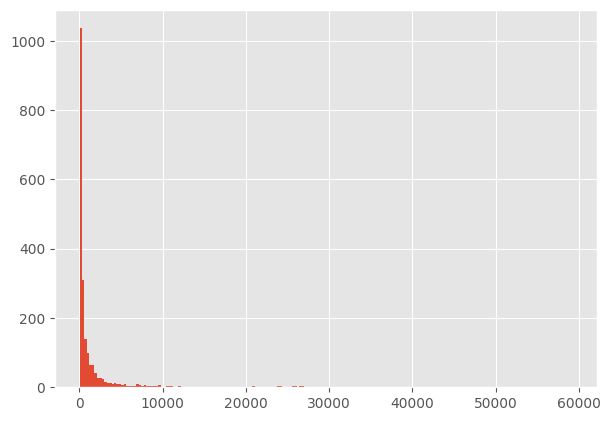

In [88]:
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize': (7,5), 'figure.dpi': 100})

n_bins = 200
hist_x, hist_y, hist_z = plt.hist(mins2tgt, bins=n_bins)

print(f"First 10 bins: {hist_x[:10]}")

In [84]:
print(f"Each bin represents around 60000/{n_bins} = {60000/n_bins} minutes = {60000/n_bins/60} hours of time,\n"
      f"which means {sum(hist_x[:1])/len(mins2tgt)*100:.1f}% of the time we reach +2% gain within {60000/n_bins/60} hours,\n"
      f"{sum(hist_x[:2])/len(mins2tgt)*100:.1f}% of the time within {2*60000/n_bins/60} hours, and so on.")


Each bin represents around 60000/200 = 300.0 minutes = 5.0 hours of time,
which means 50.1% of the time we reach +2% gain within 5.0 hours,
65.1% of the time within 10.0 hours, and so on.


In [91]:
def ema(data, n):
    alpha = 2 / (1 + n)
    return data.ewm(alpha=alpha, adjust=False).mean()

def normalise(df_orig):
    df = df_orig.copy()
    
    fields = list(df)
    
    for field in fields:
        if field in ['volume', 'trades']:
            for ma in [1, 3, 9]:
                df[f"{field}_pm_ma{ma}"] = df[field].rolling(window=ma).mean() / freq
        else:
            if field != 'close':
                df[f"{field}_norm"] = df[field] / df['close']

        if field != 'close':
            df.drop(field, axis=1, inplace=True)
    
    for x in [50, 200]:
        df[f"close_ma{x}_norm"] = df['close'].rolling(window=x).mean() / df['close']
    
    for x in [12, 26]:
        df[f"close_ema{x}_norm"] = ema(df['close'], x) / df['close']
    
    df.drop('close', axis=1, inplace=True)
    return df

df_n = normalise(df)
df_n

,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm
2021-01-01 00:00:00,0.999896,1.000262,0.999388,18.37800,NaN,NaN,6.0,NaN,NaN,NaN,NaN,1.000000,1.000000
2021-01-01 00:01:00,0.999650,1.000922,0.999164,61.89600,NaN,NaN,10.6,NaN,NaN,NaN,NaN,0.999543,0.999500
2021-01-01 00:02:00,1.001281,1.001313,0.999243,118.39200,66.222000,NaN,11.2,9.266667,NaN,NaN,NaN,1.000502,1.000510
2021-01-01 00:03:00,1.001202,1.001202,1.000000,78.21200,86.166667,NaN,10.8,10.866667,NaN,NaN,NaN,1.001720,1.001889
2021-01-01 00:04:00,1.000179,1.000715,0.999587,43.24000,79.948000,NaN,9.8,10.600000,NaN,NaN,NaN,1.001646,1.001958
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31 00:56:00,0.998772,1.000676,0.998434,35.15546,43.123520,59.025258,21.4,24.466667,30.377778,1.001310,1.010835,0.999641,1.000626
2021-05-31 00:57:00,0.998498,1.000521,0.998498,27.45456,32.090060,52.049124,25.4,22.266667,28.755556,0.999698,1.009088,0.998322,0.999074
2021-05-31 00:58:00,1.000245,1.000307,0.998651,18.40472,27.004913,46.812656,15.2,20.666667,27.222222,0.999543,1.008746,0.998373,0.998916
2021-05-31 00:59:00,1.000951,1.001166,0.999018,85.09628,43.651853,49.233393,20.4,20.333333,25.377778,1.000659,1.009697,0.999505,0.999961


In [94]:
from joblib import Parallel, delayed  

def compute_mins(i):
    t, y = minutes_to_target(df, i, target=TARGET)
    if y:
        return y
    else:
        return 120000

mins2tgt = Parallel(n_jobs=6)(delayed(compute_mins)(i) for i in tqdm(range(len(df))))

df_n['mins2tgt'] = mins2tgt

  2%|▏         | 4770/215398 [00:24<13:36, 258.10it/s]

KeyboardInterrupt: 

In [ ]:
df_n.dropna(inplace=True)